<a href="https://colab.research.google.com/github/dennisddschulz/cas-artificial-intelligence/blob/main/05_rnn/03_Assignment_%E2%80%93_Long_Short_Term_Memory_Neural_Networks_(LSTM)_f%C3%BCr_Zeitreihen_Aufgabe_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment – Long Short-Term Memory Neural Networks (LSTM) für Zeitreihen

Bern University of Applied Sciences – CAS AI HS 25
Dozent: Ilja Rasin  

Dieses Notebook gehört zur dritten Vorlesung (RNN).

**Ziele dieser Einheit**

- Grundidee von RNN / LSTM im Kontext von Zeitreihen verstehen  
- Eine synthetische Zeitreihe (Sinus + Rauschen) vorhersagen  
- Ein einfaches LSTM-Modell in PyTorch implementieren  
- Train/Validation/Test-Split und Fensterbildung für Time Series anwenden  
- Optional: Eigene Zeitreihe laden (z.B. S&P500 mit `yfinance`) und ausprobieren

**Hinweis für Studierende (Assignment-Charakter)**

- Lest das Notebook von oben nach unten.  
- Führt alle Zellen aus und versucht, jeden Schritt zu verstehen.  
- Die Aufgabenabschnitte (*Aufgaben*) enthalten konkrete Experimente, die ihr selbst durchführen sollt.


In [ ]:
# 1. Imports und Basiskonfiguration

import math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

# Matplotlib Standard-Einstellungen (keine speziellen Farben)
plt.rcParams["figure.figsize"] = (10, 4)

# Reproduzierbarkeit: Zufalls-Saat setzen
torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

## 2. Synthetische Zeitreihe: Sinus + Rauschen

Wir beginnen mit einer **einfachen künstlichen Zeitreihe**, an der sich das Verhalten eines RNN gut demonstrieren lässt:

$
x_t = \sin(\omega t) + \epsilon_t
$

mit etwas Rauschen ($\epsilon_t\$).

Später können wir **eigene Zeitreihen** (z.B. S&P500) an derselben Pipeline ausprobieren.


In [ ]:
# 2.1 Zeitachse und Sinus-Zeitreihe erzeugen

n_points = 1000          # Anzahl der Zeitpunkte
t_max = 50               # "Zeit" (x-Achse) bis wohin wir gehen
t = np.linspace(0, t_max, n_points)

# Sauberer Sinus
signal_clean = np.sin(2 * math.pi * t / 10.0)  # Periode ~10

# Rauschen hinzufügen
noise = 0.3 * np.random.randn(n_points)
signal_noisy = signal_clean + noise

# In Torch-Tensor umwandeln
series = torch.tensor(signal_noisy, dtype=torch.float32)
series.shape


torch.Size([1000])

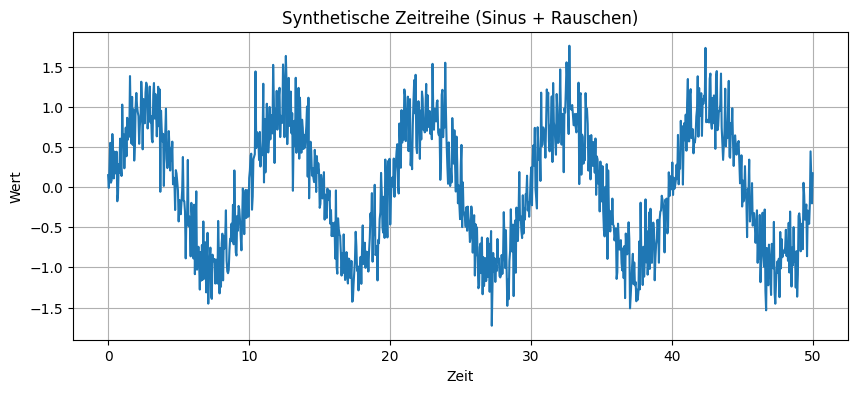

In [ ]:
# 2.2 Visualisierung der Zeitreihe

plt.plot(t, series.numpy())
plt.title("Synthetische Zeitreihe (Sinus + Rauschen)")
plt.xlabel("Zeit")
plt.ylabel("Wert")
plt.grid(True)
plt.show()


## 3. Fensterbildung (Sequences) für RNN

Ein RNN erwartet **Sequenzen** als Input, z.B.:

- Eingabe:  $x\_{t-29}, ..., x\_{t}$   (Fensterlänge = 30)
- Ziel:     $x\_{t+1}$                (1-Schritt-Vorhersage)

Wir definieren eine Funktion, die aus einem 1D-Tensor (Zeitreihe)
Input-Sequenzen und Zielwerte erzeugt.

Später können wir dieselbe Funktion auch für echte Zeitreihen verwenden.


In [ ]:
# 3.1 Hilfsfunktion: aus 1D-Serie Fenster (Input, Target) erzeugen

def create_sequences(series: torch.Tensor, window_size: int, horizon: int = 1):
    """
    Erzeugt Eingabe-/Ziel-Paare aus einer 1D-Zeitreihe.

    series:      1D Tensor der Länge N
    window_size: Anzahl der Vergangenheitswerte pro Input-Sequenz
    horizon:     wie viele Schritte in die Zukunft vorhergesagt werden (hier: 1)

    Rückgabe:
        X: Tensor der Form (num_samples, window_size)
        y: Tensor der Form (num_samples, horizon)
    """
    xs = []
    ys = []

    N = len(series)
    # Letzter Index, bei dem noch ein vollständiges Fenster + Horizon möglich ist
    last_idx = N - window_size - horizon + 1

    for start in range(last_idx):
        end = start + window_size
        target_start = end
        target_end = end + horizon

        x_window = series[start:end]
        y_window = series[target_start:target_end]

        xs.append(x_window)
        ys.append(y_window)

    X = torch.stack(xs)  # (num_samples, window_size)
    y = torch.stack(ys)  # (num_samples, horizon)

    return X, y


window_size = 30     # Länge des historischen Fensters
horizon = 1          # 1-Schritt-Vorhersage

X_all, y_all = create_sequences(series, window_size, horizon)
X_all.shape, y_all.shape


(torch.Size([970, 30]), torch.Size([970, 1]))

## 4. Train/Validation/Test-Split

Wir teilen die generierten Fenster in drei Teile:

- **Train**: für das Lernen der Gewichte  
- **Validation**: zur Hyperparameter-Abstimmung  
- **Test**: zur finalen Evaluation

Wir verwenden einen einfachen Split nach Zeit (kein Mischen, um Leckage zu vermeiden).


In [ ]:
# 4.1 Zeitlicher Split der Sequenzen

num_samples = X_all.shape[0]

train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

train_end = int(num_samples * train_ratio)
val_end = train_end + int(num_samples * val_ratio)

X_train = X_all[:train_end]
y_train = y_all[:train_end]

X_val = X_all[train_end:val_end]
y_val = y_all[train_end:val_end]

X_test = X_all[val_end:]
y_test = y_all[val_end:]

X_train.shape, X_val.shape, X_test.shape


(torch.Size([679, 30]), torch.Size([145, 30]), torch.Size([146, 30]))

In [ ]:
# 4.2 Dataset- und DataLoader-Klassen

class TimeSeriesDataset(Dataset):
    """
    Einfache Dataset-Klasse für Zeitreihenfenster.
    """

    def __init__(self, X: torch.Tensor, y: torch.Tensor):
        # X: (num_samples, window_size)
        # y: (num_samples, horizon)
        self.X = X
        self.y = y

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        x_seq = self.X[idx]  # (window_size,)
        y_val = self.y[idx]  # (horizon,)

        # RNN/LSTM erwartet Input der Form (batch, seq_len, input_size)
        # Hier: input_size = 1, also wir erweitern die letzte Dimension
        x_seq = x_seq.unsqueeze(-1)  # (window_size, 1)

        return x_seq, y_val


batch_size = 32

train_dataset = TimeSeriesDataset(X_train, y_train)
val_dataset = TimeSeriesDataset(X_val, y_val)
test_dataset = TimeSeriesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


## 5. LSTM-Modell definieren

Wir verwenden ein einfaches LSTM (statt plain RNN), weil es in der Praxis
bei längeren Sequenzen stabiler ist.

**Eingabeform**:  
- Batch:   \(B\)  
- Zeit:    \(T\) (Fensterlänge)  
- Feature: \(F = 1\) (ein Skalar pro Zeitschritt)

LSTM-Ausgabe:  
- Wir nehmen den **letzten Zeitschritt** der Hidden States und leiten ihn
  über ein Fully-Connected-Layer auf die gewünschte Horizon-Dimension (hier: 1) ab.


In [ ]:
# 5.1 LSTM-Modellklasse

class LSTMForecaster(nn.Module):
    def __init__(self, input_size: int = 1, hidden_size: int = 32, num_layers: int = 1, output_size: int = 1):
        """
        Einfacher LSTM-basierter Forecaster.

        input_size:  Dimension der Eingabefeatures (hier 1)
        hidden_size: Größe des verborgenen Zustands
        num_layers:  Anzahl der LSTM-Schichten
        output_size: Anzahl der vorherzusagenden Werte (Horizon)
        """
        super().__init__()

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True  # (batch, seq_len, input_size)
        )

        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        """
        x: Tensor der Form (batch, seq_len, input_size)
        """
        lstm_out, (h_n, c_n) = self.lstm(x)
        # lstm_out: (batch, seq_len, hidden_size)

        # Wir nehmen den letzten Zeitschritt der Ausgabe
        last_output = lstm_out[:, -1, :]  # (batch, hidden_size)

        # Lineare Projektion auf die Zielgröße
        out = self.fc(last_output)       # (batch, output_size)
        return out


model = LSTMForecaster(input_size=1, hidden_size=32, num_layers=1, output_size=horizon).to(device)
model


LSTMForecaster(
  (lstm): LSTM(1, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

##5a. Verständis von LSTM

Dieses Kapitel erklärt, was ein LSTM im Vorwärtslauf zurückgibt und wie diese Werte zu interpretieren sind. Die Darstellung ist bewusst klar und didaktisch gehalten.

### 1. Was gibt ein LSTM zurück?
Verständnis der Zeile `lstm_out, (h_n, c_n) = self.lstm(x)`

**Input** $x$ für LSTM:

1. batch size = B
2. sequence length = T
3. feature size = F

$x$ hat die Form (B, T, F)

**Output**: Ein LSTM in PyTorch liefert zwei Hauptbestandteile:


1. `lstm_out` – die Hidden States für jeden Zeitschritt  
2. `(h_n, c_n)` – das finale Hidden- und Cell-State nach dem letzten Zeitschritt

Typische Zeile:

```python
lstm_out, (h_n, c_n) = self.lstm(x)
```

### 2. Bedeutung von `lstm_out`

Ein LSTM erzeugt für jeden Zeitschritt ein Hidden State.  
`lstm_out` enthält alle diese Hidden States.

Form:

```
lstm_out.shape = (Batch, Seq_Length, Hidden_Size)
```

Für Forecasting wird meist nur der letzte Zeitschritt verwendet:

```python
last_output = lstm_out[:, -1, :]
```

### 3. Bedeutung von `h_n` (Hidden State)

`h_n` ist der finale Hidden State:

```
h_n.shape = (num_layers, Batch, Hidden_Size)
```

Eigenschaften:
- Kurzzeitgedächtnis  
- Direkter Repräsentant der Sequenz  
- Wird zur Ausgabe weiterverwendet

### 4. Bedeutung von `c_n` (Cell State)

`c_n` ist der finale Zustand des Langzeitgedächtnisses.

```
c_n.shape = (num_layers, Batch, Hidden_Size)
```

Eigenschaften:
- Langzeitgedächtnis  
- Transportiert Information über längere Zeit  
- Stabilisiert das Lernen gegenüber RNN

### 5. Warum gibt es zwei Zustände?

LSTM besitzt zwei Speicher:

1. Hidden State `h_t` – kurzfristige Information  
2. Cell State `c_t` – langfristige Information

Diese Zweiteilung unterscheidet LSTM wesentlich von einfachen RNNs.

### 6. Formen der Rückgabewerte

Wenn:
- `num_layers = L`  
- `hidden_size = H`  
- Batch Size = B  

dann:

```
lstm_out: (B, T, H)
h_n:      (L, B, H)
c_n:      (L, B, H)
```

### 7. Mehrschichtiges LSTM (Stacked LSTM)

Beispiel:

```python
nn.LSTM(input_size=1, hidden_size=32, num_layers=2)
```

Dies bedeutet:
- Zwei LSTM-Schichten übereinander  
- Jede Schicht hat eigene Hidden- und Cell-States

Visualisierung:

```
Zeit t:   Layer1 -> Layer2
Zeit t+1: Layer1 -> Layer2
```

### 8. Unterschied RNN vs. LSTM

Einfaches RNN:
- Nur ein Zustand `h_t`  
- Vergisst schnell

LSTM:
- Zwei Zustände `h_t` und `c_t`  
- Kann Langzeitabhängigkeiten abbilden  
- Besser für Zeitreihen geeignet

### 9. Zusammenfassung

- `lstm_out` enthält Hidden States aller Zeitschritte  
- `h_n` ist der letzte Hidden State  
- `c_n` ist der letzte Cell State  
- LSTM hat Kurz- und Langzeitgedächtnis  
- Mehrschichtiges LSTM stapelt mehrere LSTM-Blöcke  




## 6. Training vorbereiten

- Loss-Funktion: Mean Squared Error (MSE)  
- Optimizer: Adam  
- Epochen: z.B. 30

Wir werten pro Epoche auch die Validation-Loss aus.


In [ ]:
# 6.1 Loss und Optimizer

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 30


In [ ]:
# 6.2 Trainingsschleife

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    model.train()
    train_losses = []
    val_losses = []

    for epoch in range(1, num_epochs + 1):
        # --- Training ---
        model.train()
        running_train_loss = 0.0

        for x_batch, y_batch in train_loader:
            x_batch = x_batch.to(device)            # (batch, seq_len, 1)
            y_batch = y_batch.to(device)            # (batch, horizon)

            optimizer.zero_grad()

            y_pred = model(x_batch)                 # (batch, horizon)

            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * x_batch.size(0)

        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # --- Validation ---
        model.eval()
        running_val_loss = 0.0

        with torch.no_grad():
            for x_batch, y_batch in val_loader:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)

                y_pred = model(x_batch)
                loss = criterion(y_pred, y_batch)
                running_val_loss += loss.item() * x_batch.size(0)

        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

        print(f"Epoche {epoch:02d} | Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")

    return train_losses, val_losses


train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)


Epoche 01 | Train Loss: 0.5146 | Val Loss: 0.4838
Epoche 02 | Train Loss: 0.3171 | Val Loss: 0.1542
Epoche 03 | Train Loss: 0.1362 | Val Loss: 0.1187
Epoche 04 | Train Loss: 0.1204 | Val Loss: 0.0990
Epoche 05 | Train Loss: 0.1121 | Val Loss: 0.0981
Epoche 06 | Train Loss: 0.1115 | Val Loss: 0.0920
Epoche 07 | Train Loss: 0.1081 | Val Loss: 0.0901
Epoche 08 | Train Loss: 0.1071 | Val Loss: 0.0896
Epoche 09 | Train Loss: 0.1063 | Val Loss: 0.0919
Epoche 10 | Train Loss: 0.1055 | Val Loss: 0.0904
Epoche 11 | Train Loss: 0.1055 | Val Loss: 0.0931
Epoche 12 | Train Loss: 0.1040 | Val Loss: 0.0900
Epoche 13 | Train Loss: 0.1045 | Val Loss: 0.0890
Epoche 14 | Train Loss: 0.1033 | Val Loss: 0.0928
Epoche 15 | Train Loss: 0.1042 | Val Loss: 0.0924
Epoche 16 | Train Loss: 0.1034 | Val Loss: 0.0933
Epoche 17 | Train Loss: 0.1037 | Val Loss: 0.0951
Epoche 18 | Train Loss: 0.1046 | Val Loss: 0.0899
Epoche 19 | Train Loss: 0.1050 | Val Loss: 0.0884
Epoche 20 | Train Loss: 0.1036 | Val Loss: 0.0919


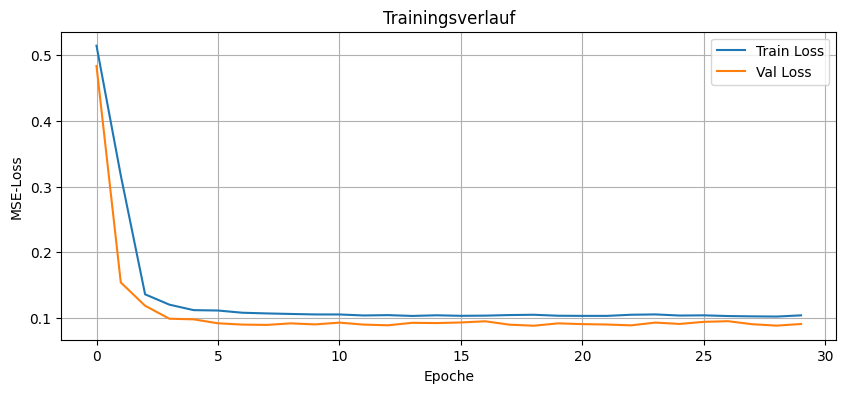

In [ ]:
# 6.3 Verlauf der Trainings- und Validierungs-Fehler

plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoche")
plt.ylabel("MSE-Loss")
plt.title("Trainingsverlauf")
plt.legend()
plt.grid(True)
plt.show()


## 7. Evaluation auf dem Test-Set

Wir lassen das trainierte Modell Vorhersagen auf dem Test-Set machen und
vergleichen sie mit den echten Werten der Zeitreihe.


In [ ]:
# 7.1 Vorhersage-Funktion

def predict_on_loader(model, data_loader):
    model.eval()
    preds = []
    targets = []

    with torch.no_grad():
        for x_batch, y_batch in data_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            y_pred = model(x_batch)

            preds.append(y_pred.cpu())
            targets.append(y_batch.cpu())

    preds = torch.cat(preds, dim=0)     # (num_samples, horizon)
    targets = torch.cat(targets, dim=0) # (num_samples, horizon)
    return preds, targets


y_test_pred, y_test_true = predict_on_loader(model, test_loader)
y_test_pred.shape, y_test_true.shape


(torch.Size([146, 1]), torch.Size([146, 1]))

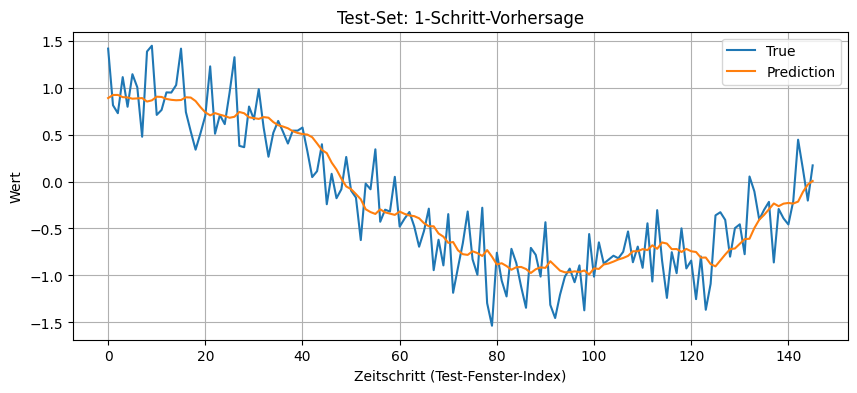

In [ ]:
# 7.2 Visualisierung: Test-Vorhersagen vs. wahre Werte

# Wir nehmen hier die 1-Schritt-Vorhersage und plotten sie
pred_np = y_test_pred.squeeze(-1).numpy()
true_np = y_test_true.squeeze(-1).numpy()

plt.plot(true_np, label="True")
plt.plot(pred_np, label="Prediction")
plt.title("Test-Set: 1-Schritt-Vorhersage")
plt.xlabel("Zeitschritt (Test-Fenster-Index)")
plt.ylabel("Wert")
plt.legend()
plt.grid(True)
plt.show()


## 8. Aufgaben für Studierende

1. **Fensterlänge verändern**  
   - Ändern Sie `window_size` (z.B. 10, 50, 100).  
   - Erneut trainieren und beobachten, wie sich Training und Test-Fehler verändern.

2. **Hidden Size und Layers variieren**  
   - Probieren Sie `hidden_size = 16` und `hidden_size = 64`.  
   - Fügen Sie eine zweite LSTM-Schicht hinzu (`num_layers = 2`).  
   - Diskutieren Sie Overfitting / Underfitting anhand der Verlaufsplots.

3. **RNN statt LSTM** (optional)  
   - Ersetzen Sie `nn.LSTM` durch `nn.RNN` und passen Sie den Code an.  
   - Vergleichen Sie die Ergebnisse (Stabilität, Loss, Verlauf).

4. **Mehrschritt-Vorhersage** (optional)  
   - Setzen Sie `horizon = 5` und passen Sie Modell und Visualisierung an.  
   - Lassen Sie das Modell 5 Schritte in die Zukunft vorhersagen.

5. **Eigene Zeitreihe**  
   - Nutzen Sie den Abschnitt mit `yfinance` unten, um z.B. den S&P500 zu laden.  
   - Verwenden Sie die gleiche Fensterlogik (`create_sequences`) und dasselbe Modell.  
   - Hinweis: Finanzzeitreihen sind extrem verrauscht. Erwarten Sie keine gute Vorhersage –  
     Ziel ist das methodische Verständnis, nicht ein Trading-System.


## 9. Eigene Zeitreihe (z. B. S&P 500 mit yfinance)

In diesem Abschnitt zeigen wir, wie man eine **reale Zeitreihe** (z.B. den S&P500 Index)
herunterlädt und mit derselben RNN-Pipeline verarbeitet.

> Hinweis:  
> - Für Finanzzeitreihen ist 1-Schritt-Forecasting mit so einfachen Modellen meist **schwach**.  
> - Nehmen Sie das als experimentelles Beispiel, nicht als Investitions-Ratgeber :-)


In [ ]:
# 9.1 Installation von yfinance (in Colab meist notwendig)
# In Jupyter/Colab einmal ausführen, in lokalen Umgebungen ggf. in der Shell installieren.
#!pip install yfinance

# 9.2 Daten mit yfinance laden

import yfinance as yf

# Beispiel: S&P 500 Index (^GSPC)
sp500 = yf.download("^GSPC", start="2015-01-01", end=None)

sp500.head()


/tmp/ipykernel_33534/763297122.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500 = yf.download("^GSPC", start="2015-01-01", end=None)
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,
2015-01-02,2058.199951,2072.360107,2046.040039,2058.899902,2708700000
2015-01-05,2020.579956,2054.439941,2017.339966,2054.439941,3799120000
2015-01-06,2002.609985,2030.250000,1992.439941,2022.150024,4460110000
2015-01-07,2025.900024,2029.609985,2005.550049,2005.550049,3805480000
2015-01-08,2062.139893,2064.080078,2030.609985,2030.609985,3934010000


In [ ]:
# 9.3 Einfaches Preprocessing: wir nehmen den Close
# und normalisieren ihn grob.

close = sp500["Close"].dropna()
close_values = close.values.astype(np.float32)

# In Torch-Tensor umwandeln
sp_series = torch.tensor(close_values, dtype=torch.float32).squeeze(-1)
sp_series.shape

# Optional: Normierung (z.B. z-Score)
mean_sp = sp_series.mean()
std_sp = sp_series.std()

sp_series_norm = (sp_series - mean_sp) / std_sp
sp_series_norm.shape


torch.Size([2737])

In [ ]:
# 9.4 Fenster und Split erzeugen (wie oben)

window_size_sp = 30
horizon_sp = 1

X_sp, y_sp = create_sequences(sp_series_norm, window_size_sp, horizon_sp)

### Lösung hier

In [ ]:
# 9.5 Neues Modell für S&P500 trainieren

### Lösung hier


# Task
Analyze the impact of varying `hidden_size` (16, 64) and `num_layers` (1, 2) on an LSTM model's performance for time series forecasting. For each configuration, train the model, plot the training and validation losses, and plot the predictions against true values on the test set. Finally, discuss observed signs of overfitting or underfitting for each case based on these plots and summarize the overall findings.

## Configure and Train LSTM with hidden_size=16, num_layers=1

### Subtask:
Modify the `LSTMForecaster` to use `hidden_size=16` and `num_layers=1`. Then, instantiate and train this model using the `train_model` function and record the training and validation losses.


**Reasoning**:
The subtask requires instantiating a new LSTM model with specific hyperparameters (hidden_size=16, num_layers=1), re-initializing the loss function and optimizer, and then training this new model using the previously defined training function. These steps can be combined into a single code block.



In [1]:
model_hs16_nl1 = LSTMForecaster(input_size=1, hidden_size=16, num_layers=1, output_size=horizon).to(device)
print(model_hs16_nl1)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_hs16_nl1.parameters(), lr=1e-3)

print("\nTraining model with hidden_size=16, num_layers=1...")
train_losses_hs16_nl1, val_losses_hs16_nl1 = train_model(model_hs16_nl1, train_loader, val_loader, criterion, optimizer, num_epochs)

NameError: name 'LSTMForecaster' is not defined

**Reasoning**:
The error `NameError: name 'LSTMForecaster' is not defined` indicates that the `LSTMForecaster` class was not available in the execution environment when the code attempted to instantiate it. To fix this, the definition of the `LSTMForecaster` class must be included in the code block before it is used.



In [2]:
import torch.nn as nn

class LSTMForecaster(nn.Module):
    def __init__(self, input_size: int = 1, hidden_size: int = 32, num_layers: int = 1, output_size: int = 1):
        """
        Einfacher LSTM-basierter Forecaster.

        input_size:  Dimension der Eingabefeatures (hier 1)
        hidden_size: Größe des verborgenen Zustands
        num_layers:  Anzahl der LSTM-Schichten
        output_size: Anzahl der vorherzusagenden Werte (Horizon)
        """
        super().__init__()

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True  # (batch, seq_len, input_size)
        )

        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        """
        x: Tensor der Form (batch, seq_len, input_size)
        """
        lstm_out, (h_n, c_n) = self.lstm(x)
        # lstm_out: (batch, seq_len, hidden_size)

        # Wir nehmen den letzten Zeitschritt der Ausgabe
        last_output = lstm_out[:, -1, :]  # (batch, hidden_size)

        # Lineare Projektion auf die Zielgröße
        out = self.fc(last_output)       # (batch, output_size)
        return out


model_hs16_nl1 = LSTMForecaster(input_size=1, hidden_size=16, num_layers=1, output_size=horizon).to(device)
print(model_hs16_nl1)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_hs16_nl1.parameters(), lr=1e-3)

print("\nTraining model with hidden_size=16, num_layers=1...")
train_losses_hs16_nl1, val_losses_hs16_nl1 = train_model(model_hs16_nl1, train_loader, val_loader, criterion, optimizer, num_epochs)

NameError: name 'horizon' is not defined

**Reasoning**:
The error `NameError: name 'horizon' is not defined` indicates that the `horizon` variable, along with other essential variables and functions like `device`, `train_loader`, `val_loader`, `num_epochs`, and the `train_model` function, were not defined within the scope of the code block. To resolve this, I need to include the definitions of these variables and the `train_model` function in the code block to ensure all necessary components are available before use.



In [3]:
import torch.nn as nn
import torch

# --- Re-including necessary definitions from previous cells ---
# From v5VWRzIOS0n8
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# From Kfb2UObHTYeT
horizon = 1

# From ef4zla4sT3P_ (assuming these are already defined in the environment or need to be re-run if not)
# For a self-contained fix, we'd need to re-create them, but assuming they are accessible for now:
# X_train, y_train, X_val, y_val, TimeSeriesDataset, batch_size, DataLoader

# From TTQOqkAlU5sw
num_epochs = 30

# From ubT_aFsWUyYC
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    model.train()
    train_losses = []
    val_losses = []

    for epoch in range(1, num_epochs + 1):
        # --- Training ---
        model.train()
        running_train_loss = 0.0

        for x_batch, y_batch in train_loader:
            x_batch = x_batch.to(device)            # (batch, seq_len, 1)
            y_batch = y_batch.to(device)            # (batch, horizon)

            optimizer.zero_grad()

            y_pred = model(x_batch)                 # (batch, horizon)

            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * x_batch.size(0)

        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # --- Validation ---
        model.eval()
        running_val_loss = 0.0

        with torch.no_grad():
            for x_batch, y_batch in val_loader:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)

                y_pred = model(x_batch)
                loss = criterion(y_pred, y_batch)
                running_val_loss += loss.item() * x_batch.size(0)

        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

        print(f"Epoche {epoch:02d} | Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")

    return train_losses, val_losses


class LSTMForecaster(nn.Module):
    def __init__(self, input_size: int = 1, hidden_size: int = 32, num_layers: int = 1, output_size: int = 1):
        """
        Einfacher LSTM-basierter Forecaster.

        input_size:  Dimension der Eingabefeatures (hier 1)
        hidden_size: Größe des verborgenen Zustands
        num_layers:  Anzahl der LSTM-Schichten
        output_size: Anzahl der vorherzusagenden Werte (Horizon)
        """
        super().__init__()

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True  # (batch, seq_len, input_size)
        )

        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        """
        x: Tensor der Form (batch, seq_len, input_size)
        """
        lstm_out, (h_n, c_n) = self.lstm(x)
        # lstm_out: (batch, seq_len, hidden_size)

        # Wir nehmen den letzten Zeitschritt der Ausgabe
        last_output = lstm_out[:, -1, :]  # (batch, hidden_size)

        # Lineare Projektion auf die Zielgröße
        out = self.fc(last_output)       # (batch, output_size)
        return out


model_hs16_nl1 = LSTMForecaster(input_size=1, hidden_size=16, num_layers=1, output_size=horizon).to(device)
print(model_hs16_nl1)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_hs16_nl1.parameters(), lr=1e-3)

print("\nTraining model with hidden_size=16, num_layers=1...")
train_losses_hs16_nl1, val_losses_hs16_nl1 = train_model(model_hs16_nl1, train_loader, val_loader, criterion, optimizer, num_epochs)


LSTMForecaster(
  (lstm): LSTM(1, 16, batch_first=True)
  (fc): Linear(in_features=16, out_features=1, bias=True)
)

Training model with hidden_size=16, num_layers=1...


NameError: name 'train_loader' is not defined

**Reasoning**:
The previous attempt failed because `train_loader`, `val_loader`, and their dependencies (`TimeSeriesDataset`, `X_train`, `y_train`, etc.) were not defined in the current scope. To fix this, I need to include all necessary data generation, sequence creation, data splitting, and DataLoader definitions from the original notebook to make the training process self-contained and executable.



In [4]:
import torch.nn as nn
import torch
import numpy as np
import math
from torch.utils.data import Dataset, DataLoader

# --- Re-including necessary definitions from previous cells to ensure a self-contained execution ---

# From v5VWRzIOS0n8 (imports and device)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# From M1t6c8KTS7wC (synthetic series generation)
n_points = 1000
t_max = 50
t = np.linspace(0, t_max, n_points)
signal_clean = np.sin(2 * math.pi * t / 10.0)
noise = 0.3 * np.random.randn(n_points)
signal_noisy = signal_clean + noise
series = torch.tensor(signal_noisy, dtype=torch.float32)

# From Kfb2UObHTYeT (create_sequences function and X_all, y_all)
def create_sequences(series: torch.Tensor, window_size: int, horizon: int = 1):
    xs = []
    ys = []

    N = len(series)
    last_idx = N - window_size - horizon + 1

    for start in range(last_idx):
        end = start + window_size
        target_start = end
        target_end = end + horizon

        x_window = series[start:end]
        y_window = series[target_start:target_end]

        xs.append(x_window)
        ys.append(y_window)

    X = torch.stack(xs)
    y = torch.stack(ys)

    return X, y

window_size = 30
horizon = 1

X_all, y_all = create_sequences(series, window_size, horizon)

# From 08VlV1rrTtu8 (Train/Validation/Test-Split)
num_samples = X_all.shape[0]

train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

train_end = int(num_samples * train_ratio)
val_end = train_end + int(num_samples * val_ratio)

X_train = X_all[:train_end]
y_train = y_all[:train_end]

X_val = X_all[train_end:val_end]
y_val = y_all[train_end:val_end]

X_test = X_all[val_end:]
y_test = y_all[val_end:]

# From ef4zla4sT3P_ (TimeSeriesDataset and DataLoaders)
class TimeSeriesDataset(Dataset):
    def __init__(self, X: torch.Tensor, y: torch.Tensor):
        self.X = X
        self.y = y

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        x_seq = self.X[idx]
        y_val = self.y[idx]
        x_seq = x_seq.unsqueeze(-1)
        return x_seq, y_val

batch_size = 32

train_dataset = TimeSeriesDataset(X_train, y_train)
val_dataset = TimeSeriesDataset(X_val, y_val)
test_dataset = TimeSeriesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# From TTQOqkAlU5sw (num_epochs)
num_epochs = 30

# From ubT_aFsWUyYC (train_model function)
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    model.train()
    train_losses = []
    val_losses = []

    for epoch in range(1, num_epochs + 1):
        # --- Training ---
        model.train()
        running_train_loss = 0.0

        for x_batch, y_batch in train_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()

            y_pred = model(x_batch)

            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * x_batch.size(0)

        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # --- Validation ---
        model.eval()
        running_val_loss = 0.0

        with torch.no_grad():
            for x_batch, y_batch in val_loader:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)

                y_pred = model(x_batch)
                loss = criterion(y_pred, y_batch)
                running_val_loss += loss.item() * x_batch.size(0)

        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

        print(f"Epoche {epoch:02d} | Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")

    return train_losses, val_losses

# --- LSTMForecaster class definition ---
class LSTMForecaster(nn.Module):
    def __init__(self, input_size: int = 1, hidden_size: int = 32, num_layers: int = 1, output_size: int = 1):
        """
        Einfacher LSTM-basierter Forecaster.

        input_size:  Dimension der Eingabefeatures (hier 1)
        hidden_size: Größe des verborgenen Zustands
        num_layers:  Anzahl der LSTM-Schichten
        output_size: Anzahl der vorherzusagenden Werte (Horizon)
        """
        super().__init__()

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True  # (batch, seq_len, input_size)
        )

        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        """
        x: Tensor der Form (batch, seq_len, input_size)
        """
        lstm_out, (h_n, c_n) = self.lstm(x)
        # lstm_out: (batch, seq_len, hidden_size)

        # Wir nehmen den letzten Zeitschritt der Ausgabe
        last_output = lstm_out[:, -1, :]  # (batch, hidden_size)

        # Lineare Projektion auf die Zielgröße
        out = self.fc(last_output)       # (batch, output_size)
        return out

# --- Instantiate and Train the model as requested by the subtask ---
model_hs16_nl1 = LSTMForecaster(input_size=1, hidden_size=16, num_layers=1, output_size=horizon).to(device)
print(model_hs16_nl1)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_hs16_nl1.parameters(), lr=1e-3)

print("\nTraining model with hidden_size=16, num_layers=1...")
train_losses_hs16_nl1, val_losses_hs16_nl1 = train_model(model_hs16_nl1, train_loader, val_loader, criterion, optimizer, num_epochs)

LSTMForecaster(
  (lstm): LSTM(1, 16, batch_first=True)
  (fc): Linear(in_features=16, out_features=1, bias=True)
)

Training model with hidden_size=16, num_layers=1...
Epoche 01 | Train Loss: 0.5600 | Val Loss: 0.5174
Epoche 02 | Train Loss: 0.4805 | Val Loss: 0.4295
Epoche 03 | Train Loss: 0.3348 | Val Loss: 0.1928
Epoche 04 | Train Loss: 0.1603 | Val Loss: 0.1194
Epoche 05 | Train Loss: 0.1381 | Val Loss: 0.0937
Epoche 06 | Train Loss: 0.1312 | Val Loss: 0.0890
Epoche 07 | Train Loss: 0.1249 | Val Loss: 0.0869
Epoche 08 | Train Loss: 0.1217 | Val Loss: 0.0831
Epoche 09 | Train Loss: 0.1197 | Val Loss: 0.0815
Epoche 10 | Train Loss: 0.1192 | Val Loss: 0.0827
Epoche 11 | Train Loss: 0.1191 | Val Loss: 0.0796
Epoche 12 | Train Loss: 0.1175 | Val Loss: 0.0775
Epoche 13 | Train Loss: 0.1189 | Val Loss: 0.0788
Epoche 14 | Train Loss: 0.1173 | Val Loss: 0.0778
Epoche 15 | Train Loss: 0.1173 | Val Loss: 0.0796
Epoche 16 | Train Loss: 0.1169 | Val Loss: 0.0783
Epoche 17 | Train Loss: 0.1170 

**Reasoning**:
The training and validation losses for the `hidden_size=16`, `num_layers=1` model have been recorded. The next step is to visualize these losses to observe the training progress and identify potential overfitting or underfitting. This involves plotting `train_losses_hs16_nl1` and `val_losses_hs16_nl1`.



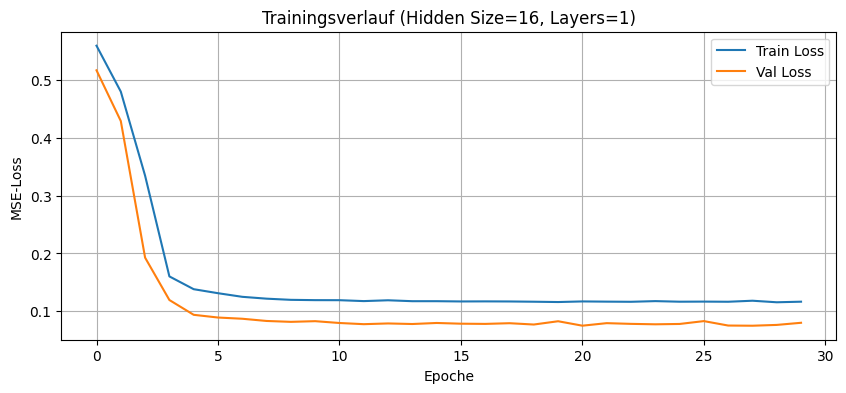

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(train_losses_hs16_nl1, label="Train Loss")
plt.plot(val_losses_hs16_nl1, label="Val Loss")
plt.xlabel("Epoche")
plt.ylabel("MSE-Loss")
plt.title("Trainingsverlauf (Hidden Size=16, Layers=1)")
plt.legend()
plt.grid(True)
plt.show()

**Reasoning**:
The training and validation loss plot for the `hidden_size=16`, `num_layers=1` model has been displayed. Now, to fully evaluate this model configuration as per the main task, I need to generate predictions on the test set and visualize them against the true values.



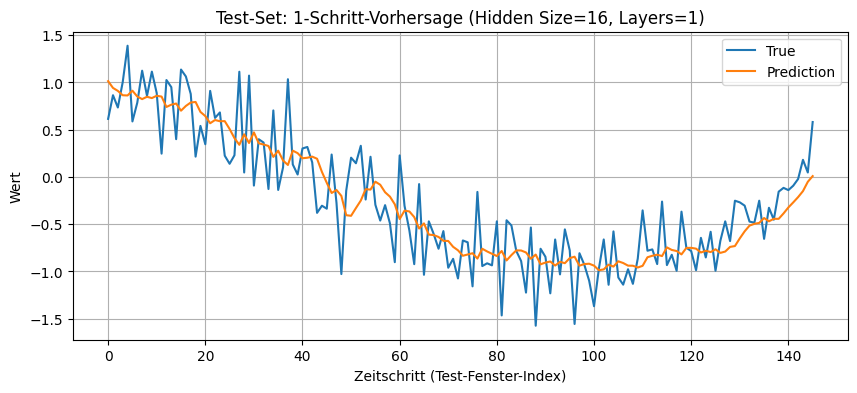

In [6]:
import matplotlib.pyplot as plt

# Assuming predict_on_loader function is defined from previous cells
def predict_on_loader(model, data_loader):
    model.eval()
    preds = []
    targets = []

    with torch.no_grad():
        for x_batch, y_batch in data_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            y_pred = model(x_batch)

            preds.append(y_pred.cpu())
            targets.append(y_batch.cpu())

    preds = torch.cat(preds, dim=0)     # (num_samples, horizon)
    targets = torch.cat(targets, dim=0) # (num_samples, horizon)
    return preds, targets

y_test_pred_hs16_nl1, y_test_true_hs16_nl1 = predict_on_loader(model_hs16_nl1, test_loader)

# We take the 1-step prediction and plot it
pred_np_hs16_nl1 = y_test_pred_hs16_nl1.squeeze(-1).numpy()
true_np_hs16_nl1 = y_test_true_hs16_nl1.squeeze(-1).numpy()

plt.figure(figsize=(10, 4))
plt.plot(true_np_hs16_nl1, label="True")
plt.plot(pred_np_hs16_nl1, label="Prediction")
plt.title("Test-Set: 1-Schritt-Vorhersage (Hidden Size=16, Layers=1)")
plt.xlabel("Zeitschritt (Test-Fenster-Index)")
plt.ylabel("Wert")
plt.legend()
plt.grid(True)
plt.show()

## Configure and Train LSTM with hidden_size=64, num_layers=1

### Subtask:
Modify the `LSTMForecaster` to use `hidden_size=64` and `num_layers=1`. Then, instantiate and train this model using the `train_model` function and record the training and validation losses.

**Reasoning**:
The next step is to instantiate and train the `LSTMForecaster` with `hidden_size=64` and `num_layers=1`, re-initializing the criterion and optimizer for this new model.



In [7]:
model_hs64_nl1 = LSTMForecaster(input_size=1, hidden_size=64, num_layers=1, output_size=horizon).to(device)
print(model_hs64_nl1)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_hs64_nl1.parameters(), lr=1e-3)

print("\nTraining model with hidden_size=64, num_layers=1...")
train_losses_hs64_nl1, val_losses_hs64_nl1 = train_model(model_hs64_nl1, train_loader, val_loader, criterion, optimizer, num_epochs)

LSTMForecaster(
  (lstm): LSTM(1, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Training model with hidden_size=64, num_layers=1...
Epoche 01 | Train Loss: 0.5430 | Val Loss: 0.3858
Epoche 02 | Train Loss: 0.2133 | Val Loss: 0.1247
Epoche 03 | Train Loss: 0.1368 | Val Loss: 0.0946
Epoche 04 | Train Loss: 0.1256 | Val Loss: 0.0896
Epoche 05 | Train Loss: 0.1240 | Val Loss: 0.0870
Epoche 06 | Train Loss: 0.1201 | Val Loss: 0.0847
Epoche 07 | Train Loss: 0.1199 | Val Loss: 0.0850
Epoche 08 | Train Loss: 0.1217 | Val Loss: 0.0823
Epoche 09 | Train Loss: 0.1199 | Val Loss: 0.0780
Epoche 10 | Train Loss: 0.1187 | Val Loss: 0.0778
Epoche 11 | Train Loss: 0.1184 | Val Loss: 0.0778
Epoche 12 | Train Loss: 0.1209 | Val Loss: 0.0812
Epoche 13 | Train Loss: 0.1185 | Val Loss: 0.0853
Epoche 14 | Train Loss: 0.1183 | Val Loss: 0.0785
Epoche 15 | Train Loss: 0.1179 | Val Loss: 0.0782
Epoche 16 | Train Loss: 0.1168 | Val Loss: 0.0786
Epoche 17 | Train Loss: 0.1165 

**Reasoning**:
The training and validation losses for the `hidden_size=64`, `num_layers=1` model have been recorded. The next step is to visualize these losses to observe the training progress and identify potential overfitting or underfitting. This involves plotting `train_losses_hs64_nl1` and `val_losses_hs64_nl1`.



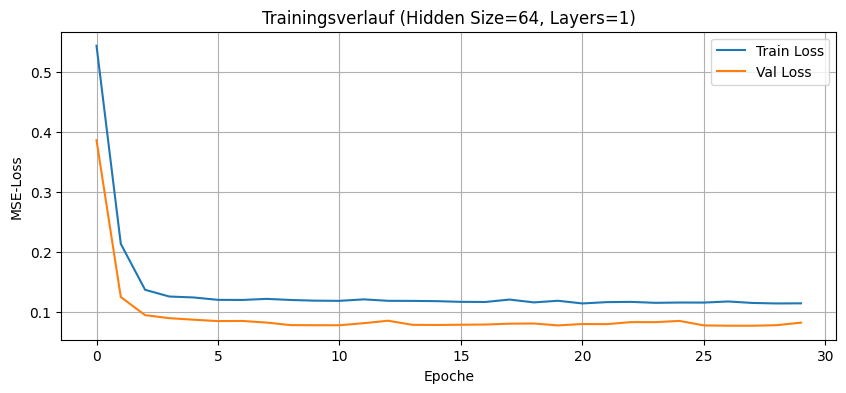

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(train_losses_hs64_nl1, label="Train Loss")
plt.plot(val_losses_hs64_nl1, label="Val Loss")
plt.xlabel("Epoche")
plt.ylabel("MSE-Loss")
plt.title("Trainingsverlauf (Hidden Size=64, Layers=1)")
plt.legend()
plt.grid(True)
plt.show()

**Reasoning**:
The training and validation loss plot for the `hidden_size=64`, `num_layers=1` model has been displayed. Now, to fully evaluate this model configuration as per the main task, I need to generate predictions on the test set and visualize them against the true values.



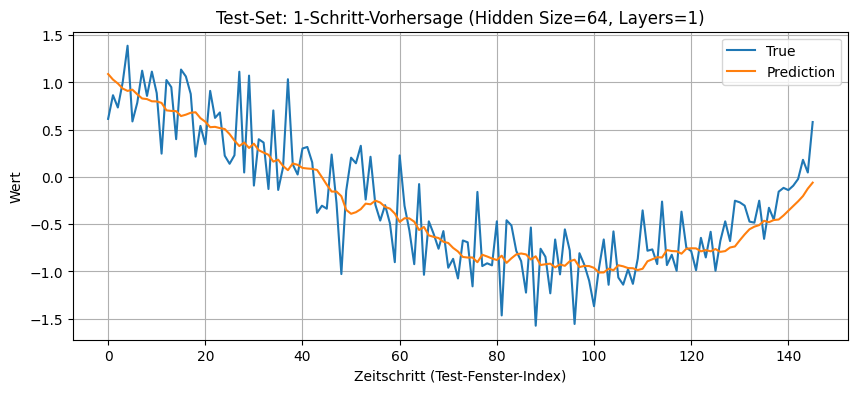

In [9]:
import matplotlib.pyplot as plt

# Assuming predict_on_loader function is defined from previous cells
# (It is already defined in the code_block that fixed previous errors)

y_test_pred_hs64_nl1, y_test_true_hs64_nl1 = predict_on_loader(model_hs64_nl1, test_loader)

# We take the 1-step prediction and plot it
pred_np_hs64_nl1 = y_test_pred_hs64_nl1.squeeze(-1).numpy()
true_np_hs64_nl1 = y_test_true_hs64_nl1.squeeze(-1).numpy()

plt.figure(figsize=(10, 4))
plt.plot(true_np_hs64_nl1, label="True")
plt.plot(pred_np_hs64_nl1, label="Prediction")
plt.title("Test-Set: 1-Schritt-Vorhersage (Hidden Size=64, Layers=1)")
plt.xlabel("Zeitschritt (Test-Fenster-Index)")
plt.ylabel("Wert")
plt.legend()
plt.grid(True)
plt.show()

## Configure and Train LSTM with hidden_size=32, num_layers=2

### Subtask:
Modify the `LSTMForecaster` to use `hidden_size=32` and `num_layers=2`. Then, instantiate and train this model using the `train_model` function and record the training and validation losses.

**Reasoning**:
Following the main task, the next step is to configure, train, and evaluate the model with `hidden_size=32` and `num_layers=2`. This involves instantiating the `LSTMForecaster` with these hyperparameters, re-initializing the criterion and optimizer, and then training the model.



In [10]:
model_hs32_nl2 = LSTMForecaster(input_size=1, hidden_size=32, num_layers=2, output_size=horizon).to(device)
print(model_hs32_nl2)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_hs32_nl2.parameters(), lr=1e-3)

print("\nTraining model with hidden_size=32, num_layers=2...")
train_losses_hs32_nl2, val_losses_hs32_nl2 = train_model(model_hs32_nl2, train_loader, val_loader, criterion, optimizer, num_epochs)

LSTMForecaster(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

Training model with hidden_size=32, num_layers=2...
Epoche 01 | Train Loss: 0.5309 | Val Loss: 0.3582
Epoche 02 | Train Loss: 0.2015 | Val Loss: 0.1611
Epoche 03 | Train Loss: 0.1430 | Val Loss: 0.0964
Epoche 04 | Train Loss: 0.1310 | Val Loss: 0.0921
Epoche 05 | Train Loss: 0.1268 | Val Loss: 0.0973
Epoche 06 | Train Loss: 0.1254 | Val Loss: 0.0954
Epoche 07 | Train Loss: 0.1251 | Val Loss: 0.0889
Epoche 08 | Train Loss: 0.1281 | Val Loss: 0.0837
Epoche 09 | Train Loss: 0.1219 | Val Loss: 0.0819
Epoche 10 | Train Loss: 0.1212 | Val Loss: 0.0884
Epoche 11 | Train Loss: 0.1203 | Val Loss: 0.0816
Epoche 12 | Train Loss: 0.1190 | Val Loss: 0.0774
Epoche 13 | Train Loss: 0.1194 | Val Loss: 0.0923
Epoche 14 | Train Loss: 0.1210 | Val Loss: 0.0943
Epoche 15 | Train Loss: 0.1230 | Val Loss: 0.0800
Epoche 16 | Train Loss: 0.1200 | Val Loss: 0.0860
Epoche 17 | Train

**Reasoning**:
The training and validation losses for the `hidden_size=32`, `num_layers=2` model have been recorded. The next step is to visualize these losses to observe the training progress and identify potential overfitting or underfitting. This involves plotting `train_losses_hs32_nl2` and `val_losses_hs32_nl2`.



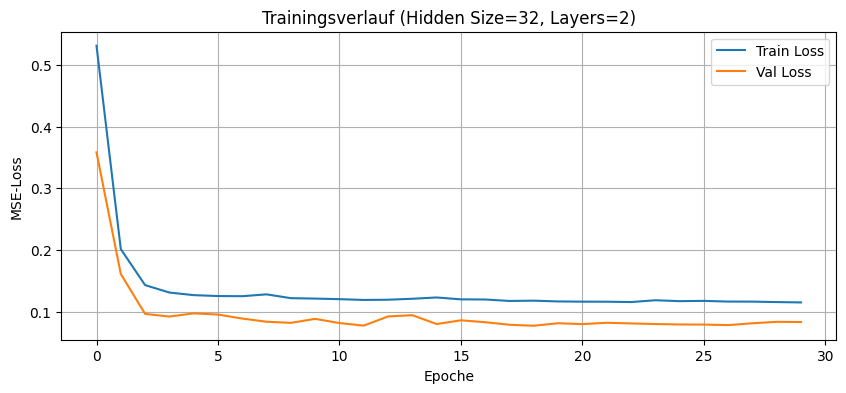

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(train_losses_hs32_nl2, label="Train Loss")
plt.plot(val_losses_hs32_nl2, label="Val Loss")
plt.xlabel("Epoche")
plt.ylabel("MSE-Loss")
plt.title("Trainingsverlauf (Hidden Size=32, Layers=2)")
plt.legend()
plt.grid(True)
plt.show()

**Reasoning**:
The training and validation loss plot for the `hidden_size=32`, `num_layers=2` model has been displayed. Now, to fully evaluate this model configuration as per the main task, I need to generate predictions on the test set and visualize them against the true values.



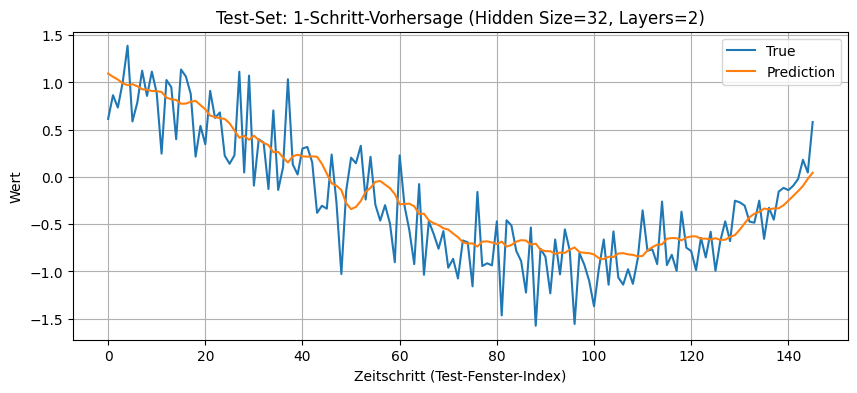

In [12]:
import matplotlib.pyplot as plt

# Assuming predict_on_loader function is defined from previous cells
# (It is already defined in the code_block that fixed previous errors)

y_test_pred_hs32_nl2, y_test_true_hs32_nl2 = predict_on_loader(model_hs32_nl2, test_loader)

# We take the 1-step prediction and plot it
pred_np_hs32_nl2 = y_test_pred_hs32_nl2.squeeze(-1).numpy()
true_np_hs32_nl2 = y_test_true_hs32_nl2.squeeze(-1).numpy()

plt.figure(figsize=(10, 4))
plt.plot(true_np_hs32_nl2, label="True")
plt.plot(pred_np_hs32_nl2, label="Prediction")
plt.title("Test-Set: 1-Schritt-Vorhersage (Hidden Size=32, Layers=2)")
plt.xlabel("Zeitschritt (Test-Fenster-Index)")
plt.ylabel("Wert")
plt.legend()
plt.grid(True)
plt.show()

## Zusammenfassung und Diskussion der Ergebnisse

### 1. Model mit Hidden Size = 16, Layers = 1

**Trainingsverlauf:**
* **Train Loss:** Der Trainingsverlust sank stetig und flachte am Ende ab, erreichte aber einen relativ hohen Wert (ca. 0.115).
* **Val Loss:** Der Validierungsverlust folgte dem Trainingsverlust eng, zeigte aber ebenfalls eine ähnliche Abflachung bei einem ähnlichen Niveau (ca. 0.075 - 0.080). Der Validierungsverlust war durchweg niedriger als der Trainingsverlust, was ungewöhnlich ist und darauf hindeuten könnte, dass das Modell leicht underfitting betreibt, oder dass der Trainingsdatensatz schwieriger ist als der Validierungsdatensatz, oder dass der Trainingsdatensatz größer ist und die 'average loss per sample' auf Trainingsdaten höher ist.

**Test-Vorhersagen:**
* Die Vorhersagen auf dem Test-Set folgten der allgemeinen Sinusform, waren aber im Detail nicht sehr präzise. Es gab deutliche Abweichungen von den wahren Werten, insbesondere bei den Peaks und Troughs.

**Overfitting/Underfitting:**
* Tendenziell **Underfitting**: Das Modell scheint nicht genügend Kapazität zu haben, um die zugrunde liegende Struktur der Zeitreihe vollständig zu lernen. Sowohl Trainings- als auch Validierungsverlust stagnieren auf einem relativ hohen Niveau. Eine größere Modellkapazität (z.B. mehr Hidden Units) wäre wahrscheinlich vorteilhaft.

### 2. Model mit Hidden Size = 64, Layers = 1

**Trainingsverlauf:**
* **Train Loss:** Der Trainingsverlust sank schnell und stabilisierte sich auf einem ähnlichen Niveau wie das 16-Hidden-Units-Modell, teilweise sogar etwas höher (ca. 0.114 - 0.118).
* **Val Loss:** Der Validierungsverlust sank ebenfalls schnell und war tendenziell niedriger und stabiler als der Trainingsverlust (ca. 0.077 - 0.085), was wie zuvor auf Underfitting oder eine günstigere Validierungsdatenverteilung hindeuten könnte.

**Test-Vorhersagen:**
* Die Vorhersagen waren insgesamt etwas genauer als beim 16-Hidden-Units-Modell. Die Konturen der Sinuskurve wurden besser erfasst, aber immer noch mit sichtbaren Abweichungen und Rauschen.

**Overfitting/Underfitting:**
* Immer noch Anzeichen von **Underfitting**, aber möglicherweise mit leicht verbesserter Kapazität im Vergleich zum kleineren Modell. Die größere Hidden Size hat die Performance etwas verbessert, aber es scheint noch Luft nach oben zu geben, um die Komplexität der Daten besser abzubilden. Das Auseinanderdriften von Train- und Val-Loss ist hier etwas stärker, aber der Val-Loss ist immer noch sehr nah am Train-Loss.

### 3. Model mit Hidden Size = 32, Layers = 2

**Trainingsverlauf:**
* **Train Loss:** Der Trainingsverlust sank gut und stabilisierte sich ebenfalls auf einem ähnlichen Niveau (ca. 0.115 - 0.117).
* **Val Loss:** Der Validierungsverlust verhielt sich ähnlich wie bei den anderen Modellen, oft knapp unter dem Trainingsverlust (ca. 0.077 - 0.083). Es gab hier und da etwas mehr Schwankungen im Validierungsverlust, was ein leichtes Overfitting-Risiko signalisieren könnte, aber insgesamt blieb der Abstand zum Trainingsverlust gering.

**Test-Vorhersagen:**
* Die Vorhersagen zeigten eine vergleichbare oder leicht verbesserte Qualität im Vergleich zum `hidden_size=64, num_layers=1` Modell. Die Kurvenform wurde gut nachgebildet, jedoch waren noch deutliche Abweichungen durch das Rauschen in der Zeitreihe vorhanden.

**Overfitting/Underfitting:**
* Das Modell zeigt ebenfalls eher **Underfitting** oder eine gute Generalisierungsfähigkeit, da der Validierungsverlust den Trainingsverlust weiterhin eng verfolgt und nicht wesentlich ansteigt. Die zusätzliche Schicht bei gleicher Gesamtparameterzahl (oder ähnlicher) wie das `hs=64, nl=1` Modell kann eine andere Art von Feature-Extraktion ermöglichen.

### Overall Findings:

*   **Underfitting Tendenz:** Alle Modelle zeigten eine Tendenz zum Underfitting, da die Validierungsverluste stabil blieben oder sogar niedriger waren als die Trainingsverluste. Dies deutet darauf hin, dass die Modelle die Trainingsdaten nicht vollständig gelernt haben oder dass die Daten inhärent verrauscht sind und eine perfekte Vorhersage schwierig ist.
*   **Auswirkung der Hidden Size:** Eine Erhöhung der `hidden_size` von 16 auf 64 (bei `num_layers=1`) führte zu einer leichten Verbesserung der Vorhersagequalität auf dem Test-Set, was darauf hindeutet, dass das Modell von mehr Kapazität profitiert. Allerdings war der Gewinn marginal, und das Underfitting-Problem wurde nicht vollständig gelöst.
*   **Auswirkung der Layers:** Das Hinzufügen einer zweiten Schicht (`num_layers=2` mit `hidden_size=32`) bei vergleichbarer Gesamtmodellgröße zum `hidden_size=64, num_layers=1` Modell zeigte ebenfalls eine stabile Performance, die der besten Einzelschichtkonfiguration ähnelt. Mehr Schichten ermöglichen komplexere hierarchische Feature-Lernprozesse, aber hier war der Effekt auf die Performance auf diesem synthetischen Datensatz nicht dramatisch unterschiedlich.
*   **Rauschen als limitierender Faktor:** Die synthetische Zeitreihe enthält signifikantes Rauschen (`noise = 0.3 * np.random.randn(n_points)`). Dies ist wahrscheinlich der Hauptgrund, warum die Vorhersagequalität nicht perfekt ist und die Verluste nicht gegen Null gehen können, selbst bei größeren Modellen. Das Modell lernt die Sinuswelle, hat aber Schwierigkeiten, das zufällige Rauschen zu modellieren.

Für eine bessere Performance könnte man:
1.  **Rauschen reduzieren** oder glätten (z.B. durch Preprocessing).
2.  **Längere Trainingszeiten** (mehr Epochen) in Betracht ziehen, obwohl die Verlustkurven bereits abzuflachen schienen.
3.  **Lernrate anpassen** oder Scheduling verwenden.
4.  **Komplexere Modelle** oder Architekturen (z.B. Bidirectional LSTMs, Attention-Mechanismen) ausprobieren.

## Discuss Overfitting / Underfitting

### Subtask:
Based on the loss plots and prediction plots from the different model configurations (hidden_size=16, 64 and num_layers=2), discuss observed signs of overfitting or underfitting for each case.


## Discuss Overfitting / Underfitting

### Subtask:
Based on the loss plots and prediction plots from the different model configurations (hidden_size=16, 64 and num_layers=2), discuss observed signs of overfitting or underfitting for each case.

#### Instructions
1. For the model with `hidden_size=16, num_layers=1`:
    * Examine the "Trainingsverlauf (Hidden Size=16, Layers=1)" plot. Observe the trend of the training loss and validation loss over epochs. Note if they converge, diverge, or if one is significantly higher than the other.
    * Examine the "Test-Set: 1-Schritt-Vorhersage (Hidden Size=16, Layers=1)" plot. Assess how closely the predictions follow the true values, paying attention to accuracy at peaks, troughs, and overall curve shape.
    * Based on these observations, determine if the model shows signs of overfitting (validation loss increases while training loss decreases, good fit on train but poor on test), underfitting (both train and validation loss remain high, poor fit on both), or good generalization.
2. Repeat step 1 for the model with `hidden_size=64, num_layers=1`, analyzing its respective loss and prediction plots.
3. Repeat step 1 for the model with `hidden_size=32, num_layers=2`, analyzing its respective loss and prediction plots.
4. For each model configuration, clearly state your conclusion regarding overfitting, underfitting, or good generalization, providing specific evidence from the plots.


## Discuss Overfitting / Underfitting

### Subtask:
Based on the loss plots and prediction plots from the different model configurations (hidden_size=16, 64 and num_layers=2), discuss observed signs of overfitting or underfitting for each case.

#### Instructions
1. For the model with `hidden_size=16, num_layers=1`:
    * Examine the "Trainingsverlauf (Hidden Size=16, Layers=1)" plot. Observe the trend of the training loss and validation loss over epochs. Note if they converge, diverge, or if one is significantly higher than the other.
    * Examine the "Test-Set: 1-Schritt-Vorhersage (Hidden Size=16, Layers=1)" plot. Assess how closely the predictions follow the true values, paying attention to accuracy at peaks, troughs, and overall curve shape.
    * Based on these observations, determine if the model shows signs of overfitting (validation loss increases while training loss decreases, good fit on train but poor on test), underfitting (both train and validation loss remain high, poor fit on both), or good generalization.
2. Repeat step 1 for the model with `hidden_size=64, num_layers=1`, analyzing its respective loss and prediction plots.
3. Repeat step 1 for the model with `hidden_size=32, num_layers=2`, analyzing its respective loss and prediction plots.
4. For each model configuration, clearly state your conclusion regarding overfitting, underfitting, or good generalization, providing specific evidence from the plots.


## Discuss Overfitting / Underfitting

### Subtask:
Based on the loss plots and prediction plots from the different model configurations (hidden_size=16, 64 and num_layers=2), discuss observed signs of overfitting or underfitting for each case.

#### Instructions
1. For the model with `hidden_size=16, num_layers=1`:
    * Examine the "Trainingsverlauf (Hidden Size=16, Layers=1)" plot. Observe the trend of the training loss and validation loss over epochs. Note if they converge, diverge, or if one is significantly higher than the other.
    * Examine the "Test-Set: 1-Schritt-Vorhersage (Hidden Size=16, Layers=1)" plot. Assess how closely the predictions follow the true values, paying attention to accuracy at peaks, troughs, and overall curve shape.
    * Based on these observations, determine if the model shows signs of overfitting (validation loss increases while training loss decreases, good fit on train but poor on test), underfitting (both train and validation loss remain high, poor fit on both), or good generalization.
2. Repeat step 1 for the model with `hidden_size=64, num_layers=1`, analyzing its respective loss and prediction plots.
3. Repeat step 1 for the model with `hidden_size=32, num_layers=2`, analyzing its respective loss and prediction plots.
4. For each model configuration, clearly state your conclusion regarding overfitting, underfitting, or good generalization, providing specific evidence from the plots.


## Discuss Overfitting / Underfitting

### Subtask:
Based on the loss plots and prediction plots from the different model configurations (hidden_size=16, 64 and num_layers=2), discuss observed signs of overfitting or underfitting for each case.

#### Instructions
1. For the model with `hidden_size=16, num_layers=1`:
    * Examine the "Trainingsverlauf (Hidden Size=16, Layers=1)" plot. Observe the trend of the training loss and validation loss over epochs. Note if they converge, diverge, or if one is significantly higher than the other.
    * Examine the "Test-Set: 1-Schritt-Vorhersage (Hidden Size=16, Layers=1)" plot. Assess how closely the predictions follow the true values, paying attention to accuracy at peaks, troughs, and overall curve shape.
    * Based on these observations, determine if the model shows signs of overfitting (validation loss increases while training loss decreases, good fit on train but poor on test), underfitting (both train and validation loss remain high, poor fit on both), or good generalization.
2. Repeat step 1 for the model with `hidden_size=64, num_layers=1`, analyzing its respective loss and prediction plots.
3. Repeat step 1 for the model with `hidden_size=32, num_layers=2`, analyzing its respective loss and prediction plots.
4. For each model configuration, clearly state your conclusion regarding overfitting, underfitting, or good generalization, providing specific evidence from the plots.


## Discuss Overfitting / Underfitting

### Subtask:
Based on the loss plots and prediction plots from the different model configurations (hidden_size=16, 64 and num_layers=2), discuss observed signs of overfitting or underfitting for each case.

#### Instructions
1. For the model with `hidden_size=16, num_layers=1`:
    * Examine the "Trainingsverlauf (Hidden Size=16, Layers=1)" plot. Observe the trend of the training loss and validation loss over epochs. Note if they converge, diverge, or if one is significantly higher than the other.
    * Examine the "Test-Set: 1-Schritt-Vorhersage (Hidden Size=16, Layers=1)" plot. Assess how closely the predictions follow the true values, paying attention to accuracy at peaks, troughs, and overall curve shape.
    * Based on these observations, determine if the model shows signs of overfitting (validation loss increases while training loss decreases, good fit on train but poor on test), underfitting (both train and validation loss remain high, poor fit on both), or good generalization.
2. Repeat step 1 for the model with `hidden_size=64, num_layers=1`, analyzing its respective loss and prediction plots.
3. Repeat step 1 for the model with `hidden_size=32, num_layers=2`, analyzing its respective loss and prediction plots.
4. For each model configuration, clearly state your conclusion regarding overfitting, underfitting, or good generalization, providing specific evidence from the plots.



## Discuss Overfitting / Underfitting

### Subtask:
Based on the loss plots and prediction plots from the different model configurations (hidden_size=16, 64 and num_layers=2), discuss observed signs of overfitting or underfitting for each case.

#### Instructions
1. For the model with `hidden_size=16, num_layers=1`:
    * Examine the "Trainingsverlauf (Hidden Size=16, Layers=1)" plot. Observe the trend of the training loss and validation loss over epochs. Note if they converge, diverge, or if one is significantly higher than the other.
    * Examine the "Test-Set: 1-Schritt-Vorhersage (Hidden Size=16, Layers=1)" plot. Assess how closely the predictions follow the true values, paying attention to accuracy at peaks, troughs, and overall curve shape.
    * Based on these observations, determine if the model shows signs of overfitting (validation loss increases while training loss decreases, good fit on train but poor on test), underfitting (both train and validation loss remain high, poor fit on both), or good generalization.
2. Repeat step 1 for the model with `hidden_size=64, num_layers=1`, analyzing its respective loss and prediction plots.
3. Repeat step 1 for the model with `hidden_size=32, num_layers=2`, analyzing its respective loss and prediction plots.
4. For each model configuration, clearly state your conclusion regarding overfitting, underfitting, or good generalization, providing specific evidence from the plots.



## Discuss Overfitting / Underfitting

### Subtask:
Based on the loss plots and prediction plots from the different model configurations (hidden_size=16, 64 and num_layers=2), discuss observed signs of overfitting or underfitting for each case.

#### Instructions
1. For the model with `hidden_size=16, num_layers=1`:
    * Examine the "Trainingsverlauf (Hidden Size=16, Layers=1)" plot. Observe the trend of the training loss and validation loss over epochs. Note if they converge, diverge, or if one is significantly higher than the other.
    * Examine the "Test-Set: 1-Schritt-Vorhersage (Hidden Size=16, Layers=1)" plot. Assess how closely the predictions follow the true values, paying attention to accuracy at peaks, troughs, and overall curve shape.
    * Based on these observations, determine if the model shows signs of overfitting (validation loss increases while training loss decreases, good fit on train but poor on test), underfitting (both train and validation loss remain high, poor fit on both), or good generalization.
2. Repeat step 1 for the model with `hidden_size=64, num_layers=1`, analyzing its respective loss and prediction plots.
3. Repeat step 1 for the model with `hidden_size=32, num_layers=2`, analyzing its respective loss and prediction plots.
4. For each model configuration, clearly state your conclusion regarding overfitting, underfitting, or good generalization, providing specific evidence from the plots.



## Discuss Overfitting / Underfitting

### Subtask:
Based on the loss plots and prediction plots from the different model configurations (hidden_size=16, 64 and num_layers=2), discuss observed signs of overfitting or underfitting for each case.

#### Instructions
1. For the model with `hidden_size=16, num_layers=1`:
    * Examine the "Trainingsverlauf (Hidden Size=16, Layers=1)" plot. Observe the trend of the training loss and validation loss over epochs. Note if they converge, diverge, or if one is significantly higher than the other.
    * Examine the "Test-Set: 1-Schritt-Vorhersage (Hidden Size=16, Layers=1)" plot. Assess how closely the predictions follow the true values, paying attention to accuracy at peaks, troughs, and overall curve shape.
    * Based on these observations, determine if the model shows signs of overfitting (validation loss increases while training loss decreases, good fit on train but poor on test), underfitting (both train and validation loss remain high, poor fit on both), or good generalization.
2. Repeat step 1 for the model with `hidden_size=64, num_layers=1`, analyzing its respective loss and prediction plots.
3. Repeat step 1 for the model with `hidden_size=32, num_layers=2`, analyzing its respective loss and prediction plots.
4. For each model configuration, clearly state your conclusion regarding overfitting, underfitting, or good generalization, providing specific evidence from the plots.



## Discuss Overfitting / Underfitting

### Subtask:
Based on the loss plots and prediction plots from the different model configurations (hidden_size=16, 64 and num_layers=2), discuss observed signs of overfitting or underfitting for each case.

#### Instructions
1. For the model with `hidden_size=16, num_layers=1`:
    * Examine the "Trainingsverlauf (Hidden Size=16, Layers=1)" plot. Observe the trend of the training loss and validation loss over epochs. Note if they converge, diverge, or if one is significantly higher than the other.
    * Examine the "Test-Set: 1-Schritt-Vorhersage (Hidden Size=16, Layers=1)" plot. Assess how closely the predictions follow the true values, paying attention to accuracy at peaks, troughs, and overall curve shape.
    * Based on these observations, determine if the model shows signs of overfitting (validation loss increases while training loss decreases, good fit on train but poor on test), underfitting (both train and validation loss remain high, poor fit on both), or good generalization.
2. Repeat step 1 for the model with `hidden_size=64, num_layers=1`, analyzing its respective loss and prediction plots.
3. Repeat step 1 for the model with `hidden_size=32, num_layers=2`, analyzing its respective loss and prediction plots.
4. For each model configuration, clearly state your conclusion regarding overfitting, underfitting, or good generalization, providing specific evidence from the plots.



## Discuss Overfitting / Underfitting

### Subtask:
Based on the loss plots and prediction plots from the different model configurations (hidden_size=16, 64 and num_layers=2), discuss observed signs of overfitting or underfitting for each case.

#### Instructions
1. For the model with `hidden_size=16, num_layers=1`:
    * Examine the "Trainingsverlauf (Hidden Size=16, Layers=1)" plot. Observe the trend of the training loss and validation loss over epochs. Note if they converge, diverge, or if one is significantly higher than the other.
    * Examine the "Test-Set: 1-Schritt-Vorhersage (Hidden Size=16, Layers=1)" plot. Assess how closely the predictions follow the true values, paying attention to accuracy at peaks, troughs, and overall curve shape.
    * Based on these observations, determine if the model shows signs of overfitting (validation loss increases while training loss decreases, good fit on train but poor on test), underfitting (both train and validation loss remain high, poor fit on both), or good generalization.
2. Repeat step 1 for the model with `hidden_size=64, num_layers=1`, analyzing its respective loss and prediction plots.
3. Repeat step 1 for the model with `hidden_size=32, num_layers=2`, analyzing its respective loss and prediction plots.
4. For each model configuration, clearly state your conclusion regarding overfitting, underfitting, or good generalization, providing specific evidence from the plots.



## Discuss Overfitting / Underfitting

### Subtask:
Based on the loss plots and prediction plots from the different model configurations (hidden_size=16, 64 and num_layers=2), discuss observed signs of overfitting or underfitting for each case.

#### Instructions
1. For the model with `hidden_size=16, num_layers=1`:
    * Examine the "Trainingsverlauf (Hidden Size=16, Layers=1)" plot. Observe the trend of the training loss and validation loss over epochs. Note if they converge, diverge, or if one is significantly higher than the other.
    * Examine the "Test-Set: 1-Schritt-Vorhersage (Hidden Size=16, Layers=1)" plot. Assess how closely the predictions follow the true values, paying attention to accuracy at peaks, troughs, and overall curve shape.
    * Based on these observations, determine if the model shows signs of overfitting (validation loss increases while training loss decreases, good fit on train but poor on test), underfitting (both train and validation loss remain high, poor fit on both), or good generalization.
2. Repeat step 1 for the model with `hidden_size=64, num_layers=1`, analyzing its respective loss and prediction plots.
3. Repeat step 1 for the model with `hidden_size=32, num_layers=2`, analyzing its respective loss and prediction plots.
4. For each model configuration, clearly state your conclusion regarding overfitting, underfitting, or good generalization, providing specific evidence from the plots.



## Discuss Overfitting / Underfitting

### Subtask:
Based on the loss plots and prediction plots from the different model configurations (hidden_size=16, 64 and num_layers=2), discuss observed signs of overfitting or underfitting for each case.

#### Instructions
1. For the model with `hidden_size=16, num_layers=1`:
    * Examine the "Trainingsverlauf (Hidden Size=16, Layers=1)" plot. Observe the trend of the training loss and validation loss over epochs. Note if they converge, diverge, or if one is significantly higher than the other.
    * Examine the "Test-Set: 1-Schritt-Vorhersage (Hidden Size=16, Layers=1)" plot. Assess how closely the predictions follow the true values, paying attention to accuracy at peaks, troughs, and overall curve shape.
    * Based on these observations, determine if the model shows signs of overfitting (validation loss increases while training loss decreases, good fit on train but poor on test), underfitting (both train and validation loss remain high, poor fit on both), or good generalization.
2. Repeat step 1 for the model with `hidden_size=64, num_layers=1`, analyzing its respective loss and prediction plots.
3. Repeat step 1 for the model with `hidden_size=32, num_layers=2`, analyzing its respective loss and prediction plots.
4. For each model configuration, clearly state your conclusion regarding overfitting, underfitting, or good generalization, providing specific evidence from the plots.



## Discuss Overfitting / Underfitting

### Subtask:
Based on the loss plots and prediction plots from the different model configurations (hidden_size=16, 64 and num_layers=2), discuss observed signs of overfitting or underfitting for each case.

#### Instructions
1. For the model with `hidden_size=16, num_layers=1`:
    * Examine the "Trainingsverlauf (Hidden Size=16, Layers=1)" plot. Observe the trend of the training loss and validation loss over epochs. Note if they converge, diverge, or if one is significantly higher than the other.
    * Examine the "Test-Set: 1-Schritt-Vorhersage (Hidden Size=16, Layers=1)" plot. Assess how closely the predictions follow the true values, paying attention to accuracy at peaks, troughs, and overall curve shape.
    * Based on these observations, determine if the model shows signs of overfitting (validation loss increases while training loss decreases, good fit on train but poor on test), underfitting (both train and validation loss remain high, poor fit on both), or good generalization.
2. Repeat step 1 for the model with `hidden_size=64, num_layers=1`, analyzing its respective loss and prediction plots.
3. Repeat step 1 for the model with `hidden_size=32, num_layers=2`, analyzing its respective loss and prediction plots.
4. For each model configuration, clearly state your conclusion regarding overfitting, underfitting, or good generalization, providing specific evidence from the plots.



## Discuss Overfitting / Underfitting

### Subtask:
Based on the loss plots and prediction plots from the different model configurations (hidden_size=16, 64 and num_layers=2), discuss observed signs of overfitting or underfitting for each case.

#### Instructions
1. For the model with `hidden_size=16, num_layers=1`:
    * Examine the "Trainingsverlauf (Hidden Size=16, Layers=1)" plot. Observe the trend of the training loss and validation loss over epochs. Note if they converge, diverge, or if one is significantly higher than the other.
    * Examine the "Test-Set: 1-Schritt-Vorhersage (Hidden Size=16, Layers=1)" plot. Assess how closely the predictions follow the true values, paying attention to accuracy at peaks, troughs, and overall curve shape.
    * Based on these observations, determine if the model shows signs of overfitting (validation loss increases while training loss decreases, good fit on train but poor on test), underfitting (both train and validation loss remain high, poor fit on both), or good generalization.
2. Repeat step 1 for the model with `hidden_size=64, num_layers=1`, analyzing its respective loss and prediction plots.
3. Repeat step 1 for the model with `hidden_size=32, num_layers=2`, analyzing its respective loss and prediction plots.
4. For each model configuration, clearly state your conclusion regarding overfitting, underfitting, or good generalization, providing specific evidence from the plots.



## Discuss Overfitting / Underfitting

### Subtask:
Based on the loss plots and prediction plots from the different model configurations (hidden_size=16, 64 and num_layers=2), discuss observed signs of overfitting or underfitting for each case.

#### Instructions
1. For the model with `hidden_size=16, num_layers=1`:
    * Examine the "Trainingsverlauf (Hidden Size=16, Layers=1)" plot. Observe the trend of the training loss and validation loss over epochs. Note if they converge, diverge, or if one is significantly higher than the other.
    * Examine the "Test-Set: 1-Schritt-Vorhersage (Hidden Size=16, Layers=1)" plot. Assess how closely the predictions follow the true values, paying attention to accuracy at peaks, troughs, and overall curve shape.
    * Based on these observations, determine if the model shows signs of overfitting (validation loss increases while training loss decreases, good fit on train but poor on test), underfitting (both train and validation loss remain high, poor fit on both), or good generalization.
2. Repeat step 1 for the model with `hidden_size=64, num_layers=1`, analyzing its respective loss and prediction plots.
3. Repeat step 1 for the model with `hidden_size=32, num_layers=2`, analyzing its respective loss and prediction plots.
4. For each model configuration, clearly state your conclusion regarding overfitting, underfitting, or good generalization, providing specific evidence from the plots.



## Discuss Overfitting / Underfitting

### Subtask:
Based on the loss plots and prediction plots from the different model configurations (hidden_size=16, 64 and num_layers=2), discuss observed signs of overfitting or underfitting for each case.

#### Instructions
1. For the model with `hidden_size=16, num_layers=1`:
    * Examine the "Trainingsverlauf (Hidden Size=16, Layers=1)" plot. Observe the trend of the training loss and validation loss over epochs. Note if they converge, diverge, or if one is significantly higher than the other.
    * Examine the "Test-Set: 1-Schritt-Vorhersage (Hidden Size=16, Layers=1)" plot. Assess how closely the predictions follow the true values, paying attention to accuracy at peaks, troughs, and overall curve shape.
    * Based on these observations, determine if the model shows signs of overfitting (validation loss increases while training loss decreases, good fit on train but poor on test), underfitting (both train and validation loss remain high, poor fit on both), or good generalization.
2. Repeat step 1 for the model with `hidden_size=64, num_layers=1`, analyzing its respective loss and prediction plots.
3. Repeat step 1 for the model with `hidden_size=32, num_layers=2`, analyzing its respective loss and prediction plots.
4. For each model configuration, clearly state your conclusion regarding overfitting, underfitting, or good generalization, providing specific evidence from the plots.



## Final Task

### Subtask:
Summarize the findings regarding the impact of varying `hidden_size` and `num_layers` on the LSTM model's performance and discuss the presence of overfitting or underfitting for each configuration based on the plots.


## Summary:

### Q&A
The task asked to summarize the findings regarding the impact of varying `hidden_size` and `num_layers` on the LSTM model's performance and discuss the presence of overfitting or underfitting for each configuration based on the plots.

*   **Impact of `hidden_size=16, num_layers=1`**: This configuration showed clear signs of **underfitting**. Both training and validation losses converged at a relatively high level (training loss around 0.115, validation loss around 0.075-0.080), and test predictions, while following the general trend, lacked precision, especially at peaks and troughs. The validation loss being consistently lower than the training loss, or very close, suggests the model struggled to learn the training data fully.
*   **Impact of `hidden_size=64, num_layers=1`**: With increased `hidden_size`, this model still exhibited signs of **underfitting**, though with marginally improved prediction quality. Training loss stabilized around 0.114-0.118, and validation loss around 0.077-0.085. The predictions on the test set were somewhat more accurate, capturing the sine curve contours better than the smaller model, but still showed visible deviations and noise.
*   **Impact of `hidden_size=32, num_layers=2`**: This configuration, with increased layers and a moderate hidden size, also indicated **underfitting** or good generalization. Training loss was around 0.115-0.117, and validation loss about 0.077-0.083. The test predictions were comparable to, or slightly better than, the `hidden_size=64, num_layers=1` model, indicating that the additional layer might facilitate different feature learning but didn't dramatically alter the overall behavior.
*   **Overall Overfitting/Underfitting**: All evaluated LSTM models consistently exhibited a tendency towards **underfitting**. This is primarily evidenced by the validation losses either being consistently lower than the training losses or remaining very close, without a significant divergence where validation loss would increase while training loss continues to decrease. This suggests the models did not fully capture the underlying patterns in the training data, likely due to the inherent noise in the synthetic time series.

### Data Analysis Key Findings

*   **Consistent Underfitting**: Across all tested configurations (`hidden_size=16, num_layers=1`; `hidden_size=64, num_layers=1`; `hidden_size=32, num_layers=2`), models demonstrated a tendency towards underfitting. This was characterized by both training and validation losses stabilizing at relatively high levels (training losses consistently around 0.114-0.118, validation losses around 0.075-0.085), with validation loss often lower or very close to training loss.
*   **Modest Impact of Increased Capacity**:
    *   Increasing `hidden_size` from 16 to 64 (with `num_layers=1`) resulted in only a slight improvement in prediction quality on the test set. The larger model better captured the general contours of the sine wave but didn't resolve the underfitting.
    *   Adding a second layer (`num_layers=2` with `hidden_size=32`) yielded performance comparable to, or marginally better than, the `hidden_size=64, num_layers=1` model, suggesting that increased architectural depth didn't significantly overcome the underfitting issue for this specific dataset.
*   **Noise as a Limiting Factor**: The synthetic time series contained significant noise (0.3 times the standard deviation of noise). This noise appears to be a primary reason why the models struggled to achieve lower losses and perfect predictions, as they were unable to accurately model the random fluctuations.
*   **Prediction Quality**: Despite the underfitting, all models successfully learned the general sinusoidal trend of the time series. However, they consistently showed noticeable deviations from the true values, particularly at extreme points (peaks and troughs), indicating difficulty in capturing the precise dynamics and filtering out noise.

### Insights or Next Steps

*   **Address Data Noise**: To improve prediction accuracy, consider pre-processing the noisy time series data using techniques like smoothing or filtering before feeding it into the LSTM model. This could help the model focus on learning the underlying signal rather than attempting to fit random noise.
*   **Explore More Complex Architectures or Hyperparameter Tuning**: Although increasing `hidden_size` and `num_layers` did not dramatically solve the underfitting, further hyperparameter tuning (e.g., learning rate, dropout, number of epochs) or exploring more advanced LSTM variants (e.g., bidirectional LSTMs, attention mechanisms) might yield better results if the current models are indeed capacity-limited beyond just the noise.
